<a href="https://colab.research.google.com/github/IFuentesSR/Soil_moisture/blob/main/SHAP_toy_examples_for_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To obtain access to the datasets used in this work you need to follow the following steps:
* Click on [this](https://drive.google.com/drive/u/1/folders/12cYWIfg_0wATfxxtnnhQfLHrghqazwj6) Google Drive folder link. 

* Then, right click on the **SoilMoisture** folder and select **Add shortcut to Drive**.

![picture](https://drive.google.com/uc?id=1lZqtmeemmmCM7OZUj_kiqDMMvgGS375a)

* Make a shortcut of the **SoilMoisture** folder in your own **My Drive**-folder, by clicking on **Add shortcut**. 

![picture](https://drive.google.com/uc?id=133aXjO2jrfMSj9lzK2aZNq69L6wEiKCH)

A new Google Drive folder with all the contents of this study has been linked to your Google Drive; therefore, we can link our Google Drive account to have access to the data.

# Connecting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading some libraries

In [2]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

enc = OneHotEncoder(handle_unknown='ignore')

## Connecting to reference data

In [4]:
Oznet_path = 'drive/MyDrive/SoilMoisture/oznet'
OzFlux_path = 'drive/MyDrive/SoilMoisture/ozflux'

oznet_data = [(os.path.join(Oznet_path, n), n) for n in os.listdir(Oznet_path) if n.startswith('comp2_')]
ozflux_data = [(os.path.join(OzFlux_path, n), n) for n in os.listdir(OzFlux_path) if n.startswith('comp2_')]
stations = oznet_data + ozflux_data

not_use = ['Longrea',  'ADwet_2', 'ADdry_2', 'jaxa'] #repeated or in NZ
stations = [(n, p) for n, p in stations if p[6:-4] not in not_use]

# SSMAP extent does not cover these stations
stations = [n for n in stations if ('CapeTri' not in n[1]) & ('CowBay' not in n[1])] 


## Definition of some pre-processing and plotting functions

In [5]:
def split(dataframe, test_frac, train_frac, ran=None):
    '''
    Description: Splits the data into test, training and validation
    Inputs: 
        dataframe: pandas dataframe
        test_frac: float
        train_frac: float
        ran: integer
    Outputs:
        test: pandas dataframe
        train: pandas dataframe
        validation: pandas dataframe
    '''
    dataframe.reset_index(inplace=True)
    test = dataframe.sample(frac=test_frac, random_state=0)
    training = dataframe.drop(test.index)
    training = training.sample(frac=1)
    train = training.sample(frac=train_frac, random_state=ran)
    validation = training.drop(train.index)
    return test.set_index('index'), train.set_index('index'), validation.set_index('index')


def split_train_vali(dataframe, test_frac, ran=0):
    '''
    Description: Splits the data into training and validation
    Inputs: 
        dataframe: pandas dataframe
        test_frac: float
        ran: integer
    Outputs:
        vali: pandas dataframe
        train: pandas dataframe
    '''
    dataframe.reset_index(inplace=True)
    vali = dataframe.sample(frac=test_frac, random_state=ran)
    training = dataframe.drop(vali.index)
    train = training.sample(frac=1)
    return vali.set_index('index'), train.set_index('index')


def append_sm(dataframe, tuple_station, column=1):
    '''
    Description: Appends reference soil moisture to predictors dataframe
    Inputs: 
        dataframe: pandas dataframe
        tuple_station: tuple with path to files and name of reference files
        column: integer corresponding to observation number
    Outputs:
        df: pandas dataframe
    '''
    test = pd.read_csv(tuple_station[0], encoding='latin1')
    cols = test.columns
    test['dates'] = pd.to_datetime(test[cols[0]],
                                   format='%Y-%m-%d %H:%M:%S')
    test = test.set_index('dates')
    test['sm'] = test[cols[column]].astype(float)
    resampled = test.resample('D').mean()
    resampled['sm'] = resampled['sm']/100
    df_sampled = dataframe[dataframe['id'].str.lower() == tuple_station[1][6:-4].lower()]
    df_sampledx = df_sampled.copy()
    df_sampledx['soilM'] = resampled['sm']
    df_sampledx[(df_sampledx['soilM'] < 0.0) |
                (df_sampledx['soilM'] > 1)] = np.nan
    df_sampledx[~df_sampledx.index.duplicated(keep='first')]
    df_sampledx = df_sampledx.dropna(subset=['id', 'soilM'])
    df_sampledx = df_sampledx.sort_index()
    return df_sampledx


def get_reference(tuple_station):
    '''
    Description: Creates pandas dataframe with reference data
    Inputs: 
        tuple_station: tuple with path to files and name of reference files
    Outputs:
        resampled: pandas dataframe
    '''
    test = pd.read_csv(tuple_station[0])
    cols = test.columns
    test['dates'] = pd.to_datetime(test[cols[0]],
                                   format='%Y-%m-%d %H:%M:%S')
    test = test.set_index('dates')
    test['sm'] = test[cols[1]].astype(float)
    resampled = test.resample('D').mean()

    resampled['sm'] = resampled['sm']/100
    mask = (resampled.index >= '2016-01-01') & (resampled.index < '2020-12-31')
    resampled = resampled[mask]
    resampled[(resampled['sm'] < 0.0) |
              (resampled['sm'] > 1)] = np.nan
    return resampled


## Defining modelling functions

In [12]:
def ccc(y_true, x_true):
    '''
    Description: Creates ccc loss function for tf model
    Inputs: 
        y_true: predictions
        x_true: observations
    Outputs:
        ccc loss function
    '''
    uy, ux = K.mean(y_true), K.mean(x_true)
    sxy = tfp.stats.covariance(y_true, x_true)
    sy, sx = tfp.stats.variance(y_true), tfp.stats.variance(x_true)
    E = 2*sxy/(sy+sx+K.pow(uy-ux, 2))
    return 1-E


def mlp(inputs):
    '''
    Description: Creates a MLP tf model
    Inputs: 
        inputs: list of inputs
    Outputs:
        tf model
    '''
    input = Input(shape=(len(inputs)), dtype='float32')
    hidden3 = Dense(128, activation='relu')(input)
    hidden4 = Dense(64, activation='relu')(hidden3)
    hidden5 = Dense(32, activation='relu')(hidden4)
    hidden5 = Dense(16, activation='relu')(hidden4)
    mlp_out = Dense(1, activation=lambda x: relu(x, max_value=1.0))(hidden5)

    model = Model(inputs=input, outputs=mlp_out)
    model.compile(loss=ccc, optimizer=Adam(lr=0.00003))
    return model


def model_khold(dataframe, inputs, model, test_frac, train_frac):
    '''
    Description: Returns trained tf model splitting into test, training, and validation
    Inputs: 
        dataframe: predictors dataframe
        inputs: list of inputs
        model: tf model
        test_frac: float
        train_frac: float
    Outputs:
        mdl: trained tf model
        here: dictionary with history of training
        vali_in: pd dataframe subset for validation
        DFs1: pd dataframe for predictors
    '''
    DFs = dataframe.copy()
    DFs = DFs.dropna(how='any')
    DFs = DFs.sample(frac=1)
    DFs1 = DFs[inputs]
    DFs1 = DFs1.apply(lambda x: (x - x.min())/(x.max() - x.min()))
    DFs1['soilM'], DFs1['date'], DFs1['id'] = DFs['soilM'], DFs['date'], DFs['id']
    te, tr, va = split(DFs1, test_frac, train_frac, ran=42)
    tr_in = tr[inputs].values.reshape((tr[inputs].shape[0],
                                       tr[inputs].shape[1],
                                       1)).astype('float32')
    vali_in = va[inputs].values.reshape((va[inputs].shape[0],
                                         va[inputs].shape[1],
                                         1)).astype('float32')
    tr_out, vali_out = tr['soilM'].values.astype('float32'), va['soilM'].values.astype('float32')
    mdl = model(inputs)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    here = mdl.fit(tr_in.reshape((tr_in.shape[0], tr_in.shape[1])),
                   tr_out,
                   epochs=500,
                   verbose=2,
                   batch_size=256,
                   validation_data=(vali_in.reshape((vali_in.shape[0], vali_in.shape[1])), vali_out),
                   callbacks=[callback])
    return mdl, here, tr_in, vali_in, DFs1[inputs]


## Toy example

### Loading predictors

In [7]:
df = pd.read_csv('drive/MyDrive/SoilMoisture/soil_moist_inputs.csv')
df.drop(['.geo'], inplace=True, axis=1)
df.set_index(pd.to_datetime(df['date'], format='%Y-%m-%d'), inplace=True)
df.dropna(how='any', inplace=True)
dfs = [append_sm(df, n) for n in stations]

### Setting covariate and prediction names

In [8]:
ixs = range(1, 11)
smap_cols = ['smap{}'.format(str(n)) for n in ixs]
ssmap_cols = ['ssmap{}'.format(str(n)) for n in ixs]
chirps_cols = ['chirps{}'.format(str(n)) for n in ixs]

lstm_cols = smap_cols+chirps_cols+ssmap_cols

mlp_cols = [#'hnd', 'upa', 
            'VV', 'rSSM',
            'AWC1', 'AWC2', 'AWC3', 'AWC4',
            'CLY1', 'CLY2', 'CLY3', 'CLY4',
            'SOC1', 'SOC2', 'SOC3', 'SOC4',
            'LST_Day_1km', 'LST_Night_1km',
            'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
            'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07',
            'NDVI', 'irri', 'past', 'agri', 'fore', 'sava'] 

var_in = lstm_cols + mlp_cols
var = var_in.copy()
var_y = 'soilM'
var.append(var_y)

### Setting predictors dataframe (land use to one hot encode)

In [9]:
DF = pd.concat(dfs)
DF.drop('date', axis=1, inplace=True)
DF = DF.reset_index()

DF.loc[(DF['LU'] == 7), 'LU'] = 2

DF.loc[(DF['LU'] == 11), 'LU'] = 1  # changed wetland to pasture
DF.loc[(DF['LU'] == 9), 'LU'] = 10  #shrubland (1) to savanna
enc_df = pd.DataFrame(enc.fit_transform(DF[['LU']]).toarray())
enc_df.rename(columns={0: 'irri', 1: 'past', 2: 'agri', 3: 'fore', 4: 'sava'}, inplace=True)
DF = DF.join(enc_df)

statio = DF['id'].unique().tolist()

### Training one khold model

In [10]:
whole, histo, trai, val, df_shap = model_khold(DF, var_in, mlp, 0.1, 0.9)

The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/500
23/23 - 2s - loss: 0.4157 - val_loss: 0.3620 - 2s/epoch - 79ms/step
Epoch 2/500
23/23 - 0s - loss: 0.3446 - val_loss: 0.3258 - 78ms/epoch - 3ms/step
Epoch 3/500
23/23 - 0s - loss: 0.3158 - val_loss: 0.3067 - 84ms/epoch - 4ms/step
Epoch 4/500
23/23 - 0s - loss: 0.3009 - val_loss: 0.2918 - 81ms/epoch - 4ms/step
Epoch 5/500
23/23 - 0s - loss: 0.2876 - val_loss: 0.2788 - 79ms/epoch - 3ms/step
Epoch 6/500
23/23 - 0s - loss: 0.2788 - val_loss: 0.2696 - 82ms/epoch - 4ms/step
Epoch 7/500
23/23 - 0s - loss: 0.2704 - val_loss: 0.2609 - 85ms/epoch - 4ms/step
Epoch 8/500
23/23 - 0s - loss: 0.2652 - val_loss: 0.2529 - 76ms/epoch - 3ms/step
Epoch 9/500
23/23 - 0s - loss: 0.2587 - val_loss: 0.2465 - 83ms/epoch - 4ms/step
Epoch 10/500
23/23 - 0s - loss: 0.2557 - val_loss: 0.2423 - 85ms/epoch - 4ms/step
Epoch 11/500
23/23 - 0s - loss: 0.2486 - val_loss: 0.2382 - 79ms/epoch - 3ms/step
Epoch 12/500
23/23 - 0s - loss: 0.2460 - val_loss: 0.2336 - 93ms/epoch - 4ms/step
Epoch 13/500
23/23 - 0s - 

### Some settings for using SHAP

In [11]:
warnings.filterwarnings("ignore")
explainer = shap.KernelExplainer(whole.predict, shap.kmeans(trai[:, :, 0].reshape((trai.shape[0], trai.shape[1])), 10))
shap_values = explainer.shap_values(val[:,:,0])

  0%|          | 0/627 [00:00<?, ?it/s]

Setting some labels for SHAP plot

In [14]:
SUB = str.maketrans("-0123456789", "₋₀₁₂₃₄₅₆₇₈₉")
labels = [n+' t{}'.format(i).translate(SUB) if i == 0 else n+' t-{}'.format(i).translate(SUB) for i, n in enumerate(np.repeat('SMAP', 10))]
labels2 = [n+' t{}'.format(i).translate(SUB) if i == 0 else n+' t-{}'.format(i).translate(SUB) for i, n in enumerate(np.repeat('CHIRPS', 10))]
labels3 = [n+' t{}'.format(i).translate(SUB) if i == 0 else n+' t-{}'.format(i).translate(SUB) for i, n in enumerate(np.repeat('SSMAP', 10))]
labels4 = ['VV_S1', 'rSSM_S1', 'AWC0-5'.translate(SUB), 'AWC5-15'.translate(SUB), 'AWC15-30'.translate(SUB), 'SOC30-60'.translate(SUB),
'CLAY0-5'.translate(SUB), 'CLAY5-15'.translate(SUB), 'CLAY15-30'.translate(SUB), 'CLAY30-60'.translate(SUB),
'SOC0-5'.translate(SUB), 'SOC5-15'.translate(SUB), 'SOC15-30'.translate(SUB), 'SOC30-60'.translate(SUB),
'LST_day', 'LST_night', 'MODIS_red', 'MODIS_nir', 'MODIS_blue', 'MODIS_green', 
'MODIS_swir1'.translate(SUB), 'MODIS_swir2'.translate(SUB), 'MODIS_swir3'.translate(SUB), 'NDVI', 'Irrigation', 'Agri_rainfed',
'Pasture', 'Forest', 'Savannah']
lab = labels+labels2+labels3+labels4

### SHAP plot

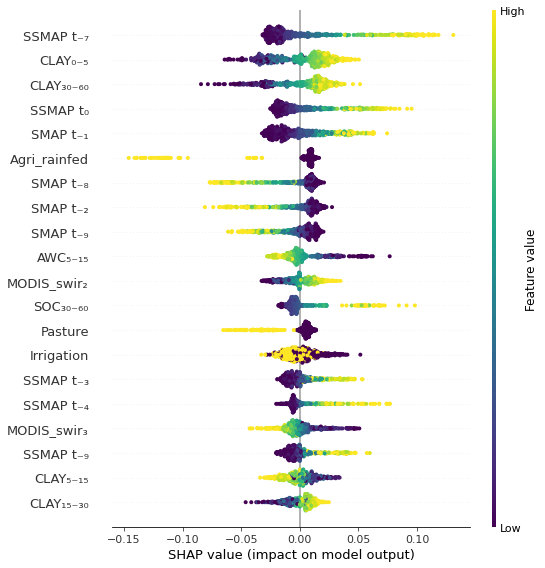

In [15]:
shap.summary_plot(shap_values[0], val[:,:,0],
                  max_display=20, plot_type='dot',
                  cmap='viridis', feature_names=lab)

### Aggregating by covariate groups

In [43]:
smap = shap_values[0][:,0:10].sum(axis=1)
ssmap = shap_values[0][:,20:30].sum(axis=1)
chirps = shap_values[0][:,10:20].sum(axis=1)
S1 = shap_values[0][:,30:32].sum(axis=1)
awc = shap_values[0][:,32:36].sum(axis=1)
clay = shap_values[0][:,36:40].sum(axis=1)
soc = shap_values[0][:,40:44].sum(axis=1)
lst = shap_values[0][:,44:46].sum(axis=1)
sr = shap_values[0][:,46:53].sum(axis=1)
ndvi = shap_values[0][:,53:54].ravel()
LU = shap_values[0][:,54:].sum(axis=1)
concate = np.stack([smap, ssmap, chirps, S1, awc, clay, soc, lst, sr, ndvi, LU])
feas = ['SMAP', 'SSMAP', 'CHIRPS', 'S1', 'AWC', 'CLAY',
        'SOC', 'MODIS LST', 'MODIS SR',
        'NDVI', 'LULC']

smap_tra = val[:,0:10].sum(axis=1).ravel()
ssmap_tra = val[:,20:30].sum(axis=1).ravel()
chirps_tra = val[:,10:20].sum(axis=1).ravel()
S1_tra = val[:,30:32].sum(axis=1).ravel()
awc_tra = val[:,32:36].sum(axis=1).ravel()
clay_tra = val[:,36:40].sum(axis=1).ravel()
soc_tra = val[:,40:44].sum(axis=1).ravel()
lst_tra = val[:,44:46].sum(axis=1).ravel()
sr_tra = val[:,46:53].sum(axis=1).ravel()
ndvi_tra = val[:,53:54].ravel()
LU_tra = val[:,54:].sum(axis=1).ravel()
concate_tra = np.stack([smap_tra, ssmap_tra, chirps_tra, S1_tra, awc_tra,
                        clay_tra, soc_tra, lst_tra, sr_tra, ndvi_tra, LU_tra])

### Aggregated SHAP plot

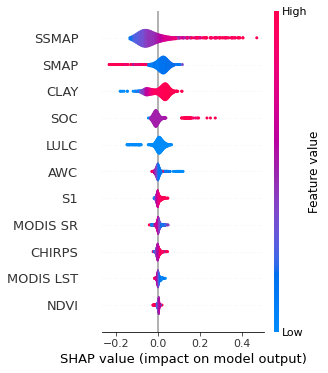

In [44]:
plt.subplot(1,2,1)
shap.summary_plot(concate.T, concate_tra.T, feature_names=feas, plot_type='violin')